## Build KNN from scratch 

In [1]:
# read in the iris data
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or 'retina'
%matplotlib inline

sns.set(context='notebook', style='whitegrid')

In [6]:
train = pd.read_csv('./data/wookiee-train.csv')
test = pd.read_csv('./data/wookiee-test.csv')

holdout = pd.read_csv('./data/wookiee-ho.csv')

In [9]:
print(train.shape)
print(test.shape)

(750, 5)
(250, 5)


In [10]:
train

,Unnamed: 0,wookieecolor,xcoord,ycoord,zcoord
0,0,red,-3.410692,0.854400,0.228154
1,1,red,0.350080,-0.751120,-1.845183
2,2,chartreuse,0.841712,-0.058204,0.246217
3,3,red,-0.646260,-1.821082,0.444616
4,4,blue,1.423538,2.269409,-1.061053
...,...,...,...,...,...
745,745,red,-0.116874,-3.500292,0.226594
746,746,white,0.916701,-0.152994,-0.133628
747,747,white,0.148534,-1.664906,-0.449369
748,748,white,0.336376,-0.507910,-0.389131


In [ ]:
# STEP 1: split X and y into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.4, 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
from sklearn import datasets

iris = datasets.load_iris()
df = pd.DataFrame(data = iris.data, columns = iris.feature_names)
df['target'] = iris.target

In [22]:
X = df.drop('target', axis=1)
y = df.target

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int64

In [28]:
print(X.iloc[0])
print(X.iloc[1])

sepal length (cm)    5.1
sepal width (cm)     3.5
petal length (cm)    1.4
petal width (cm)     0.2
Name: 0, dtype: float64
sepal length (cm)    4.9
sepal width (cm)     3.0
petal length (cm)    1.4
petal width (cm)     0.2
Name: 1, dtype: float64


### 1. Define a function to calculate distance between two points

In [38]:
def minkowski_distance(a, b, p=1):
    # store the number of dimensions
    dim = len(a)
 
    # set initial distance to 0
    distance = 0
    
    #Calculate minkowski distance using parameter p
    for d in range(dim):
        distance += abs(a[d] - b[d])**p
        
    distance = distance ** (1/p)
    
    return distance

# test function
minkowski_distance(a=X.iloc[0], b= X.iloc[1], p=1)

0.6999999999999993

In [39]:
print(X.index)

RangeIndex(start=0, stop=150, step=1)


### 2. Use the distance function to get distance between a test point and all known data points

In [41]:
test_pt = [4.8, 2.7, 2.5, 0.7]

# Calculate the distance between test_pt and all points in X

distances =[]

for i in X.index:
    distances.append(minkowski_distance(test_pt, X.iloc[i]))

df_dists = pd.DataFrame(data = distances, index = X.index, columns = ['dist'])

df_dists.head()

,dist
0,2.7
1,2.0
2,2.3
3,2.1
4,2.7


### 3. Sort distance measurements to find the points closest to the test point

In [46]:

df_nn = df_dists.sort_values(by=['dist'], axis = 0)[:5]
df_nn

,dist
98,1.4
57,1.5
93,1.7
24,1.8
30,1.8


### 4. Use majority class labels of those closest points to predict the label of the test point

Use collections.Counter to keep track of the labels that coincide with the nearest neighbor points. I then use the .most_common() method to return the most commonly occurring label. Note: if there is a tie between two or more labels for the title of “most common” label, the one that was first encountered by the Counter() object will be the one that gets returned.

In [55]:
from collections import Counter

# create counter object to track the labels

counter = Counter(y[df_nn.index])
# Get most common label of all the nearest neighbors
counter.most_common()[0][0]

1

In [56]:
counter.most_common()

[(1, 3), (0, 2)]

###  5. Repeat steps 1 through 4 until all test data points are classified

In this step, I put the code I’ve already written to work and write a function to classify the data using KNN. First, I perform a train_test_split on the data (75% train, 25% test), and then scale the data using StandardScaler(). Since KNN is distance-based, it is important to make sure that the features are scaled properly before feeding them into the algorithm.
Additionally, to avoid data leakage, it is good practice to scale the features after the train_test_split has been performed. First, scale the data from the training set only (scaler.fit_transform(X_train)), and then use that information to scale the test set (scaler.tranform(X_test)). This way, I can ensure that no information outside of the training data is used to create the model.

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Split the data - 75% trian 25% test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                    random_state=1)

#Scale the X data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [75]:
def knn_predict(X_train, X_test, y_train, y_test, k, p):
    
    # Counter to help with label voting
    from collections import Counter
    
    # Make predictions on the test data
    # Need output of 1 prediction per test data point
    y_hat_test = []
    
    for test_point in X_test:
        distances = []
        
        for train_point in X_train:
            distance = minkowski_distance(test_point, train_point, p=p)
            distances.append(distance)
            
        # Store distances in a dataframe
        df_dists = pd.DataFrame(data = distances, index = y_train.index, 
                                columns = ['dist'])
        
        # Store distances, and only consider the k colosest points
        df_nn = df_dists.sort_values(by=['dist'], axis=0)[:k]
        
        # Create counter object to track the labels of k closest neighbors
        counter = Counter(y_train[df_nn.index])
        
        # Get most common label of all the nearest neighbors
        prediction = counter.most_common()[0][0]
        
        #Append prediction to output list
        y_hat_test.append(prediction)
        
    return y_hat_test


y_hat_test = knn_predict(X_train, X_test, y_train, y_test, k=5, p=1)

print(y_hat_test)

[0, 1, 1, 0, 2, 2, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 1, 2, 2, 2, 1, 2, 2, 0, 1, 0]


In [76]:
# get the accurancy score

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_hat_test))

0.9210526315789473


### 6. Final : Let’s check the result of sklearn’s KNeighborsClassifier on the same data:

In [86]:
# Testing to see results from sklearn.neighbors.KNeighborsClassifier

from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=30, p=1)
clf.fit(X_train, y_train)

y_pred_test = clf.predict(X_test)

print(f"SKlearn KNN Accuracy: {accuracy_score(y_test, y_pred_test)}")

SKlearn KNN Accuracy: 0.9736842105263158


### Exploring the effect of varying k
 Let’s see how the classification accuracy changes when I vary k:


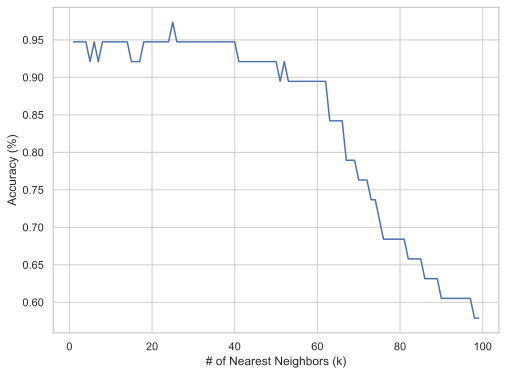

In [83]:
# Obtain accuracy score varying k from 1 to 99

accuracies = []

for k in range(1,100):
    y_hat_test = knn_predict(X_train, X_test, y_train, y_test, k , p=1)
    accuracies.append(accuracy_score(y_test, y_hat_test))
    
#Plot the results

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(range(1,100), accuracies)
ax.set_xlabel('# of Nearest Neighbors (k)')
ax.set_ylabel('Accuracy (%)'); 

#### Every neighbor gets a vote — or do they?
In writing my own KNN classifier, I chose to overlook one clear hyperparameter tuning opportunity: the weight that each of the k nearest points has in classifying a point. In sklearn’s KNeighborsClassifier, this is the weights parameter, and it can be set to ‘uniform’, ‘distance’, or another user-defined function.
When set to ‘uniform’, each of the k nearest neighbors gets an equal vote in labeling a new point. When set to ‘distance’, the neighbors in closest to the new point are weighted more heavily than the neighbors farther away. There are certainly cases where weighting by ‘distance’ would produce better results, and the only way to find out is through hyperparameter tuning.

#### Attribute to : Doug Steen
https://towardsdatascience.com/how-to-build-knn-from-scratch-in-python-5e22b8920bd2
    